In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
conn = sqlite3.connect('/content/drive/MyDrive/School21/d12/data/checking-logs.sqlite')

In [4]:
views = pd.read_sql('''SELECT * FROM pageviews''', conn)
views

,index,uid,datetime
0,0,admin_1,2020-04-17 12:01:08.463179
1,1,admin_1,2020-04-17 12:01:23.743946
2,2,admin_3,2020-04-17 12:17:39.287778
3,3,admin_3,2020-04-17 12:17:40.001768
4,4,admin_1,2020-04-17 12:27:30.646665
...,...,...,...
1075,1075,user_25,2020-05-21 23:23:49.995349
1076,1076,admin_1,2020-05-21 23:49:22.386789
1077,1077,admin_1,2020-05-22 10:36:14.662600
1078,1078,user_5,2020-05-22 11:30:18.368990


In [5]:
pageviews = pd.read_sql('''SELECT uid, COUNT(datetime) AS pageviews FROM pageviews WHERE uid LIKE 'user_%' GROUP BY uid''', conn)
pageviews

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


In [6]:
checker = pd.read_sql('''SELECT * FROM checker''', conn)
checker

,index,status,success,timestamp,numTrials,labname,uid
0,0,checking,0,2020-04-16 21:12:50.740474,5,None,admin_1
1,1,ready,0,2020-04-16 21:12:54.708365,5,code_rvw,admin_1
2,2,checking,0,2020-04-16 21:46:47.769088,7,None,admin_1
3,3,ready,0,2020-04-16 21:46:48.121217,7,lab02,admin_1
4,4,checking,0,2020-04-16 21:53:01.862637,6,code_rvw,admin_1
...,...,...,...,...,...,...,...
3397,3397,ready,0,2020-05-21 20:19:06.872761,7,laba06s,user_1
3398,3398,checking,0,2020-05-21 20:22:41.785725,8,laba06s,user_1
3399,3399,ready,0,2020-05-21 20:22:41.877806,8,laba06s,user_1
3400,3400,checking,0,2020-05-21 20:37:00.129678,9,laba06s,user_1


In [7]:
num_commits = pd.read_sql('''SELECT uid, COUNT(timestamp) as num_commits FROM checker WHERE uid LIKE 'user_%' AND labname != 'project1'
                        AND status = 'ready' GROUP BY uid''', conn)
num_commits

,uid,num_commits
0,user_0,2
1,user_1,35
2,user_10,13
3,user_11,4
4,user_12,45
5,user_13,28
6,user_14,33
7,user_15,14
8,user_16,23
9,user_17,29


In [8]:
avg = pd.read_sql('''WITH a (uid, labname, avg) AS (SELECT uid, labname, (strftime('%s', first_commit_ts) - deadlines) / 3600 AS avg
                    FROM test INNER JOIN deadlines ON test.labname = deadlines.labs WHERE labname != 'project1' AND uid IN (SELECT DISTINCT uid 
                    FROM pageviews WHERE (uid LIKE 'user_%'))) SELECT uid, AVG(avg) as avg FROM a GROUP BY uid''', conn)
avg

,uid,avg
0,user_1,-64.400000
1,user_10,-74.800000
2,user_14,-159.000000
3,user_17,-61.600000
4,user_18,-5.666667
5,user_19,-98.750000
6,user_21,-95.500000
7,user_25,-92.600000
8,user_28,-86.400000
9,user_3,-105.400000


In [9]:
conn.close()

In [10]:
df = avg.merge(pageviews, how='inner', on='uid').merge(num_commits, how='inner', on='uid')
df

,uid,avg,pageviews,num_commits
0,user_1,-64.400000,28,35
1,user_10,-74.800000,89,13
2,user_14,-159.000000,143,33
3,user_17,-61.600000,47,29
4,user_18,-5.666667,3,4
5,user_19,-98.750000,16,62
6,user_21,-95.500000,10,35
7,user_25,-92.600000,179,43
8,user_28,-86.400000,149,33
9,user_3,-105.400000,317,13


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76286700d0>,
      dtype=object)

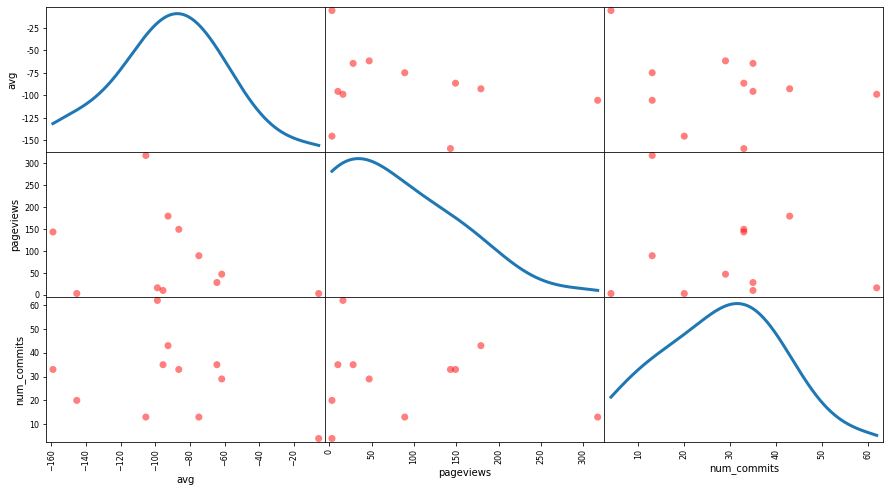

In [11]:
pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(15,8), diagonal='kde', hist_kwds=None, s=200, c='red', density_kwds={'lw': 3})

In [12]:
df[['pageviews', 'num_commits']].corr()

,pageviews,num_commits
pageviews,1.000000,-0.140916
num_commits,-0.140916,1.000000


«Верно ли, что если у пользователя меньше просмотров страницы, то он, скорее всего, имеет меньшее число коммитов?». Ответ: нет.

«Верно ли, что если у пользователя меньше просмотров страницы, то, скорее всего, у него будет небольшое среднее значение дельты (разница между датой первого коммита и сроком сдачи лабораторного задания)?». Ответ: нет.

«Верно ли, что существует много пользователей с небольшим количеством коммитов и мало пользователей с большим количеством коммитов?». Ответ: да.

«Верно ли, что существует много пользователей с небольшим средним значением дельты и мало пользователей с большим средним значением дельты?». Ответ: нет.